## 生成

In [98]:
import pyperclip
import pathlib
import pprint
import time
import re
import json
import requests
import io
import base64
from PIL import Image, PngImagePlugin


def parse_generation_data(data, type='civitai', add_prompts=None, del_prompts=None, replacements=None, del_parameters=None):
    """解析civitai网站图片配置数据"""
    # 配置项key
    keys = ['enable_hr', 'denoising_strength', 'firstphase_width', 'firstphase_height', 'hr_scale', 'hr_upscaler', 'hr_second_pass_steps', 'hr_resize_x', 'hr_resize_y', 'prompt', 'styles', 'seed', 'subseed', 'subseed_strength', 'seed_resize_from_h', 'seed_resize_from_w', 'sampler_name', 'batch_size', 'n_iter', 'steps', 'cfg_scale', 'width', 'height', 'restore_faces', 'tiling', 'negative_prompt', 'eta', 's_churn', 's_tmax', 's_tmin', 's_noise', 'override_settings', 'override_settings_restore_afterwards', 'script_args', 'sampler_index', 'script_name']
    
    mappings = {'sampler': 'sampler_index', 'hires_steps': 'hr_second_pass_steps', 'hires_upscale': 'hr_scale', 'hires_upscaler': 'hr_upscaler', 'face_restoration': 'restore_faces'}
    
    parameters = {}
    text = data.replace('\r', '')
    # 替换提示词
    if replacements:
        for k, v in replacements.items():
            text = text.replace(k, v)
    # prompt, negtive_prompt, others = re.search(r'(.*)Negative prompt: (.*)(Size:.*)', text, flags=re.DOTALL).groups()
    prompt, negtive_prompt, others = text.split('\n')
    negtive_prompt = negtive_prompt.replace('Negative prompt: ', '')
    
    # 增加或删除提示词
    if add_prompts:
        prompt += add_prompts  
    if del_prompts:
        for i in del_prompts:
            prompt = prompt.replace(i, '')        
    parameters['prompt'] = prompt
    parameters['negtive_prompt'] = negtive_prompt
    others = others.split('\n')[0]

    for i in others.split(', '):
        k, v = i.split(': ')
        k = k.lower().replace(' ', '_')
        
        if k == 'size':
            parameters['width'], parameters['height'] = [int(i) for i in v.split('x')]
            continue
        if k in mappings:
            k = mappings[k]
        try:
            v = int(v) 
        except ValueError:
            try:
                v = float(v)
            except ValueError:
                pass
        if k in keys:
            parameters[k] = v
    
    if 'restore_faces' in parameters:
        parameters['restore_faces'] = True
        
    # 删除不需要的参数
    if del_parameters:
        for i in del_parameters:
            del parameters[i]


    return parameters


def get_images(parameters, folder, random_seed=False):
    """基于配置参数生成图片并保存"""
    if random_seed:
        del parameters['seed']
    response = requests.post(url=f'{url}/sdapi/v1/txt2img', json=parameters)
    r = response.json()

    for num, i in enumerate(r['images']):
        image = Image.open(io.BytesIO(base64.b64decode(i.split(",",1)[0])))

        png_payload = {
            "image": "data:image/png;base64," + i
        }
        response2 = requests.post(url=f'{url}/sdapi/v1/png-info', json=png_payload)

        # 将参数信息写入png图片文件
        pnginfo = PngImagePlugin.PngInfo()
        pnginfo.add_text("parameters", response2.json().get("info"))
        
        # 替换文件名非法字符为下划线
        illegal_chars = r'[<>:"/\\|?*]'
        image_name = re.sub(illegal_chars, '_', parameters['prompt'][:145].replace('\n', ''))
        image.save(folder / f'{image_name}_{num}.png', pnginfo=pnginfo)
    return r


{'cfg_scale': 6,
 'denoising_strength': 0.7,
 'hr_scale': 1.5,
 'hr_second_pass_steps': 10,
 'hr_upscaler': 'Latent',
 'negtive_prompt': 'bright lantern, brightness, (nipples:1.2), pussy, '
                   'EasyNegative, (worst quality:2), (low quality:2), (normal '
                   'quality:2), lowres, normal quality, ((monochrome)), '
                   '((grayscale)), skin spots, acnes, skin blemishes, age '
                   'spot, glans,extra fingers, fewer fingers, strange fingers, '
                   'bad hand, bare thighs',
 'prompt': '1girl, (ulzzang-6500:0.7), kpop idol, yae miko, detached sleeves, '
           'bare shoulders, pink hair, long hair, japanese clothes, best '
           'quality, (painting:1.5), (hair ornament:1.35), jewelry, purple '
           'eyes, earrings, breasts, torii,  cherry blossoms,  lantern light, '
           'depth of field, detailed face, face focus, ribbon_trim, (looking '
           'at viewer:1.25), nontraditional miko, shiny skin, lo

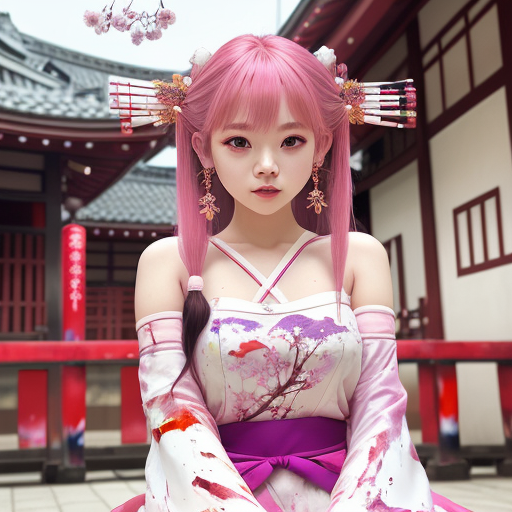

In [106]:
url = "http://127.0.0.1:7860"
folder = pathlib.Path(r"E:\novelai-webui\outputs\txt2img-images")
add_prompts = ", ulzzang-6500-v1.1_2, "
del_prompts = []
replacements = {'koreanDollLikeness_v10': 'koreanDollLikeness_v15'}
del_parameters = ['width', 'height', 'seed']

data = pyperclip.paste()
parameters = parse_generation_data(data, add_prompts=add_prompts, del_prompts=del_prompts, replacements=replacements, del_parameters=del_parameters) 
pprint.pprint(parameters)

result = get_images(parameters, folder, random_seed=False)  
image = Image.open(io.BytesIO(base64.b64decode(result['images'][-1].split(",",1)[0])))    # 最后一张图
image

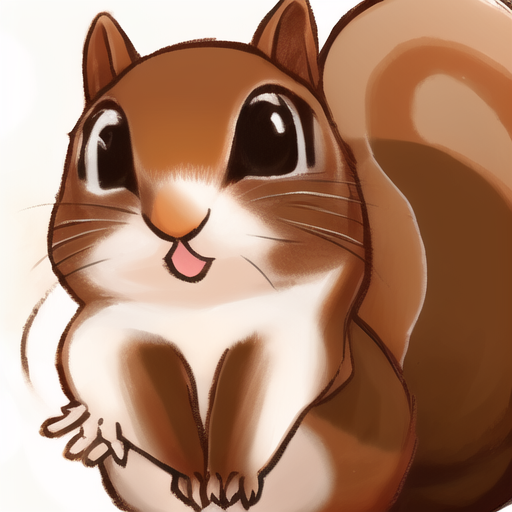

In [25]:
import webuiapi

# create API client
# api = webuiapi.WebUIApi()

# create API client with custom host, port
api = webuiapi.WebUIApi(host='127.0.0.1', port=7860)

# create API client with custom host, port and https
#api = webuiapi.WebUIApi(host='webui.example.com', port=443, use_https=True)

# create API client with default sampler, steps.
#api = webuiapi.WebUIApi(sampler='Euler a', steps=20)

# optionally set username, password when --api-auth is set on webui.
# api.set_auth('username', 'password')


result1 = api.txt2img(prompt="cute squirrel",
                    negative_prompt="ugly, out of frame",
                    seed=1003,
                    # styles=["anime"],
                    cfg_scale=7,
                     sampler_index='DDIM',
#                      steps=30,
#                      enable_hr=True,
#                      hr_scale=2,
#                      hr_upscaler=webuiapi.HiResUpscaler.Latent,
#                      hr_second_pass_steps=20,
#                      hr_resize_x=1536,
#                      hr_resize_y=1024,
#                      denoising_strength=0.4,

                    )
# images contains the returned images (PIL images)
result1.images

# image is shorthand for images[0]
result1.image

# info contains text info about the api call
result1.info

# info contains paramteres of the api call
result1.parameters

result1.image

## 训练

In [7]:
import pathlib


# folder = pathlib.Path(r"E:\lora-train\lora-scripts\train\blhx\6_blhx")
folder = pathlib.Path(r"E:\lora-train\lora-scripts\train\xianxia\6_xianxia")
txt_files = list(folder.glob("*.txt"))

In [ ]:
# 在训练文本中增加、删除tag
# add_tags = ["blhx", "1girl"]
add_tags = ["xianxia_zqx", "1girl"]
del_tags = ["transparent_background"]

original_tags = []
for txt_file in txt_files:
    with open(txt_file, 'r') as file:
        for line in file:
            tags = line.strip().split(", ") # 以逗号分隔tag
            for tag in tags:
                tag = tag.strip() # 去除tag前后的空格
                original_tags.append(tag)
                
    add_count, del_count = 0, 0
    for t in reversed(add_tags):
        if t not in original_tags:
            original_tags.insert(0, t)
            add_count += 1
    for t in del_tags:
        while t in original_tags:
            original_tags.remove(t) 
            del_count += 1
            
    with open(txt_file, 'w') as file:
        file.write(', '.join(original_tags))
    
print(f"总计增加了{add_count}个tag，删除了{del_count}个tag。")

In [8]:
# 统计tag频次
tag_counts = {} # 用于存储tag频次的字典

for txt_file in txt_files:
    with open(txt_file) as file:
        for line in file:
            tags = line.strip().split(", ") # 以逗号分隔tag
            for tag in tags:
                tag = tag.strip() # 去除tag前后的空格
                if tag not in tag_counts:
                    tag_counts[tag] = 1
                else:
                    tag_counts[tag] += 1

# 按照频次降序排列tag
sorted_tags = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)

# 输出tag及其频次
for tag, count in sorted_tags:
    print(tag, count)

solo 4703
1girl 4670
long_hair 4227
full_body 4217
breasts 3527
jewelry 2882
black_hair 1895
hair_ornament 1757
dress 1464
cleavage 1323
weapon 1178
holding 1095
navel 991
brown_hair 915
boots 779
looking_away 643
brown_eyes 636
standing 523
holding_weapon 496
thighhighs 486
armor 483
sword 463
medium_breasts 432
shiny 309
earrings 308
bracelet 307
high_heels 295
detached_sleeves 285
black_background 283
very_long_hair 279
midriff 256
cape 246
bare_shoulders 234
flower 196
shiny_hair 186
barefoot 168
fire 164
leaf 163
polearm 155
fur_trim 152
tied_hair 144
green_dress 144
holding_umbrella 130
oil-paper_umbrella 130
parasol 130
umbrella 130
red_umbrella 129
blue_umbrella 129
looking_at_viewer 126
magic 118
animal_ears 117
shoulder_armor 117
bangle 117
wide_sleeves 116
angel_wings 113
feathered_wings 113
white_wings 113
wings 113
angel 113
halo 113
lips 100
xianxia_zqx 97
butterfly 97
bug 97
crown 92
green_footwear 90
necklace 90
lipstick 89
makeup 89
shared_umbrella 88
pink_umbrella 88


## 解析图片中存储的生成参数信息

In [92]:
from PIL import Image
from PIL.ExifTags import TAGS


# 打开图片文件
image = Image.open(r'E:\novelai-webui\outputs\txt2img-images\01955-4137383039-1girl, beautiful eyes!! anime art style by kuvshinov ilya ( and wayne barlowe ) ), trending on pixiv fanbox! cgsociety digital p.png')

data = image.info['parameters']
parameters = parse_generation_data(data)
parameters

{'prompt': '1girl, beautiful eyes!! anime art style by kuvshinov ilya ( and wayne barlowe ) ), trending on pixiv fanbox! cgsociety digital painting of a chibi cat - girl holding an umbrella in the rain with wet hair flying through air. full body pose!!!! shot!!!!! dramatic lighting!!! post processing bokeh f 1 0 8 7 4 5 3 d render retro futurist illustration， <lora:xianxia_zqx:1>',
 'negtive_prompt': 'lowres, ((bad anatomy)), ((bad hands)), text, missing finger, extra digits, fewer digits, blurry, ((mutated hands and fingers)), (poorly drawn face), ((mutation)), ((deformed face)), (ugly), ((bad proportions)), ((extra limbs)), extra face, (double head), (extra head), ((extra feet)), monster, logo, cropped, worst quality, low quality, normal quality, jpeg, humpbacked, long body, long neck, ((jpeg artifacts)), painting,',
 'steps': 30,
 'sampler_index': 'Euler a',
 'cfg_scale': 5,
 'seed': 4137383039,
 'width': 512,
 'height': 768}